### From classification target to timeseries target

In [1]:
import pandas as pd
import numpy as np

from prophet.serialize import model_to_json, model_from_json
from prophet import Prophet

# loading targets
y_exh4 = pd.read_parquet('/root/data/y_exh4.parquet')

In [5]:
# prepare every target separately
col = 'Y_ЭКСГАУСТЕР А/М №4_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №4'

Основная идея в том, что заменить нули в таргете на монотонно возрастающую последовательность
Тогда такой таргет можно использовать в аддитивных моделях

In [6]:
find_span = y_exh4[[col]].copy()

# делаем сквозную нумерацию внутри группы
find_span['rn'] = find_span.rank(method='first')

# делаем сдвиг
find_span['lrn'] = find_span['rn'].shift(1).fillna(0)

# раница исходного столбца со сдвигом дает везде единицу, а в начале группы отличное от 1
find_span['rnk'] = ((find_span['rn'] - find_span['lrn']) - 1)

# делим столбец сам на себя и получаем везде NaN, где были нули
# нарастающим итогом нумеруем группы, уже каждую группу отдельно
find_span['rnk'] = (find_span['rnk']/find_span['rnk']).fillna(0).cumsum()

# Меняем, чтобы М3 было `1``, а М1 - `2` 
find_span['event'] = find_span[ col ].map( {0: 0, 2: 1, 1: 2} )
find_span['cnt'] = find_span.groupby('rnk')['rn'].transform( 'count' )
find_span['i'] = 1
find_span['grn'] = find_span.groupby('rnk')['i'].transform( 'cumsum' )

In [11]:
# делаем последовательность внутри группы монотонно возрастающей
find_span['add'] = (find_span['event'] * find_span['grn'])/( (find_span['cnt']/2)* (find_span['cnt'] + 1))

In [12]:
# проверяем, сумма должно быть или 1 или 2
find_span.groupby('rnk')['add'].sum()

rnk
0.0     0.0
1.0     1.0
2.0     2.0
3.0     1.0
4.0     0.0
5.0     2.0
6.0     0.0
7.0     1.0
8.0     0.0
9.0     1.0
10.0    0.0
11.0    1.0
Name: add, dtype: float64

<Axes: xlabel='DT'>

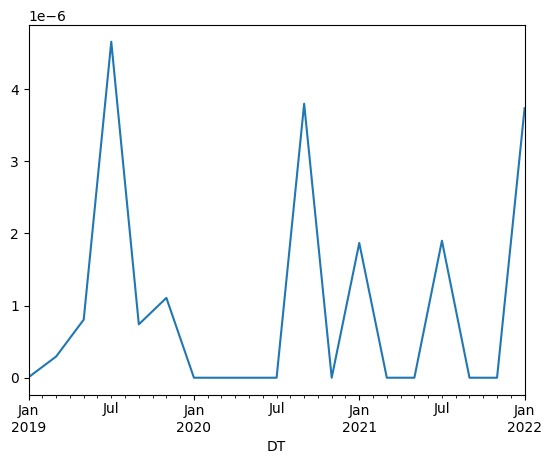

In [16]:
# Рисуем, из-за усреднения видим два скоса у вершин, но в данных только один
find_span['add'].resample('2M').mean().plot()

In [244]:
find_span['add'].reset_index().to_parquet('/root/data/y_exh4_timestamp.parquet')

In [18]:
X = pd.read_parquet('/root/data/X_exh4.parquet')

In [19]:
X['y'] = find_span['add']

In [20]:
X['ds'] = X.index

In [22]:
# горизонт предсказания 30 дней
pr = Prophet(interval_width=30*24*60*6)

In [ ]:
pr.fit(X)

19:44:29 - cmdstanpy - INFO - Chain [1] start processing
20:08:41 - cmdstanpy - INFO - Chain [1] done processing
20:08:41 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 9 Unknown error -9
Optimization terminated abnormally. Falling back to Newton.
20:14:53 - cmdstanpy - INFO - Chain [1] start processing


In [ ]:
# не получается обучть модель
# - не хватает памяти
# - что-то пушит на диск, но добавление места помогло
# - очень долго обучается, не удалось дождаться завершения процесса

In [ ]:
mj = model_to_json(pr)